In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.composition import OneOf
import glob
import os

In [5]:
# 경로 설정

data_path = '/workspace/#Ub370#Uc774#Ud130/Data'

img_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/img/train/'
img_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/img/val/'

json_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/label/train/'
json_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/label/val/'

segment_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/train/'
segment_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/'


img_path_train_anger = img_path_train + 'anger/'
img_path_val_anger = img_path_val + 'anger/'

img_path_train_happy = img_path_train + 'happy/'
img_path_val_happy = img_path_val + 'happy/'

img_path_train_panic = img_path_train + 'panic/'
img_path_val_panic = img_path_val + 'panic/'

img_path_train_sadness = img_path_train + 'sadness/'
img_path_val_sadness = img_path_val + 'sadness/'

In [6]:
# Boundind Box 좌표 정보가 담긴 csv 파일

df_train_anger = pd.read_csv(json_path_train + 'train_anger_1.csv')
df_val_anger = pd.read_csv (json_path_val + 'val_anger.csv')

df_train_happy = pd.read_csv(json_path_train + 'train_happy_1.csv')
df_val_happy = pd.read_csv (json_path_val + 'val_happy.csv')

df_train_panic = pd.read_csv(json_path_train + 'train_panic_1.csv')
df_val_panic = pd.read_csv (json_path_val + 'val_panic.csv')

df_train_sadness = pd.read_csv(json_path_train + 'train_sadness_1.csv')
df_val_sadness = pd.read_csv (json_path_val + 'val_sadness.csv')


#### 데이터 증강
- Albumentation

    - `A.Resize(640,640)` : 이미지 크기 조정
    - `A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7)` : 이미지 확대, 평행 이동, 기울임
    - `A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5)` : 이미지 평행 이동, 회전
    - `A.ElasticTransform(alpha=1, sigma=50, p=0.3)` : 이미지 왜곡 (옆모습 등)
    - `A.HorizontalFlip(p=0.5)` : 이미지 좌우 반전
    - `A.RandomBrightnessContrast(p=0.2)` : 이미지 밝기/대비 조정

In [7]:
processed_data = []

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/anger/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_anger.csv'
# input_dir = img_path_train_anger
# df = df_train_anger

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/happy/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_happy.csv'
# input_dir = img_path_train_happy
# df = df_train_happy

output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/panic/'
output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_panic.csv'
input_dir = img_path_train_panic
df = df_train_panic

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/sadness/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_sadness.csv'
# input_dir = img_path_train_sadness
# df = df_train_sadness

# 가져온 이미지 파일들 출력
for index, row in df.iterrows():
    # 이미지와 바운딩 박스를 정의 (예: [x_min, y_min, x_max, y_max])
    image = cv2.imread(input_dir + row['filename'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 바운딩 박스 좌표 (예시)
    bboxes = [
        [row['annot_A.boxes.minX'], row['annot_A.boxes.minY'], row['annot_A.boxes.maxX'], row['annot_A.boxes.maxY']],
        [row['annot_B.boxes.minX'], row['annot_B.boxes.minY'], row['annot_B.boxes.maxX'], row['annot_B.boxes.maxY']],
        [row['annot_C.boxes.minX'], row['annot_C.boxes.minY'], row['annot_C.boxes.maxX'], row['annot_C.boxes.maxY']],
        [row['avg_box.minX'], row['avg_box.minY'], row['avg_box.maxX'], row['avg_box.maxY']],
            
    ]  # 각 박스는 [x_min, y_min, x_max, y_max]
    category_ids = [1, 2, 3, 4]  # 각 바운딩 박스에 대응하는 카테고리 ID

    # 변환 파이프라인 정의 (이미지 및 바운딩 박스)
    transform = A.Compose(
        [
            A.Resize(640, 640),  # 크기 조정
            A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7), # 확대, 평행 이동, 기울임
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5), # 평행 이동, 회전
            A.ElasticTransform(alpha=1, sigma=50, p=0.3), # 왜곡(뒤틀림)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기
            A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 조정
        ], 
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_id'])
    )

    # 변환 수행
    augmented = transform(image=image, bboxes=bboxes, category_id=category_ids)

    # 변환된 이미지 및 바운딩 박스
    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']

    # 바운딩 박스 중 가장 큰 영역만 남기기
    # 면적 계산: (x_max - x_min) * (y_max - y_min)
    def get_largest_bbox(bboxes):
        largest_bbox = None
        largest_area = 0
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            area = (x_max - x_min) * (y_max - y_min)
            if area > largest_area:
                largest_area = area
                largest_bbox = bbox
        return largest_bbox
    
    # largest_bbox = get_largest_bbox(augmented_bboxes)
    # x_min, y_min, x_max, y_max = largest_bbox

    # 바운딩 박스 확인
    if not augmented_bboxes:
        print("No bounding boxes found after augmentation.")
    else:
        # 가장 큰 바운딩 박스만 남기기
        largest_bbox = get_largest_bbox(augmented_bboxes)

        if largest_bbox is None:
            print("No valid bounding boxes found.")
        else:
            x_min, y_min, x_max, y_max = largest_bbox
            print(f"Largest bounding box: {x_min}, {y_min}, {x_max}, {y_max}")

    # 처리된 이미지 저장
    os.makedirs(output_dir, exist_ok=True)
    output_path = output_dir + f"albumentation_{row['filename']}"
    cv2.imwrite(output_path, augmented_image)
    print(f"Processed and saved: {output_path}")

    # 변경된 데이터 저장
    processed_data.append({
        'filename': f"albumentation_{row['filename']}",
        'maxX': int(x_max),
        'maxY': int(y_max),
        'minX': int(x_min),
        'minY': int(y_min),
        'faceExp_uploader': row['faceExp_uploader'],
    })

# 처리된 데이터 저장
if processed_data:
    processed_df = pd.DataFrame(processed_data)
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    processed_df.to_csv(output_csv_path, index=False)
    print(f"Processed CSV saved to: {output_csv_path}")
else:
    print("No data processed.")



Largest bounding box: 309.5858459472656, 221.60528564453125, 549.7073974609375, 634.9296264648438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_twdva8d723865fa1005873a6967797c75f3dd83197f13f7daa3e3926947071al6.jpg
Largest bounding box: 1.0, 156.96621704101562, 296.8128967285156, 611.9039306640625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_tfcq8e7c42da5f56ce61f3ef372a3fe8339f467040796623e586ce3d73a97o5w4.jpg
Largest bounding box: 91.64717102050781, 455.3021240234375, 401.6218566894531, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_1x46281aba4fc588baac2be45c9ef57caaa788a14aa2bc58b228a8408c4a5ss9y.jpg
Largest bounding box: 10.320367813110352, 100.7667007446289, 344.0705261230469, 575.84326171875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_6lh809d8c75d0e1378b8d5996d86937375e05ec

Invalid SOS parameters for sequential JPEG


Largest bounding box: 384.67626953125, 0.0, 570.0489501953125, 311.31512451171875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_s8206e3bdea525e8358a4bd2c8f2ebeeab207bb21c5e572350a22c82f05c3a18q.jpg
Largest bounding box: 0.0, 112.34879302978516, 73.97291564941406, 516.1990966796875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_f41cc59ac1dc14015e41fd022709df00a561af8187f44d4c6c5b7be45d7aaphud.jpg
Largest bounding box: 273.8451232910156, 0.0, 515.4290161132812, 428.1083679199219
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_h5xi3198ff546c550f75ac04dbff0f6792d952dc367963a6044b919ce1eac6ot0.jpg
Largest bounding box: 92.48658752441406, 198.03091430664062, 390.7013244628906, 588.58642578125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_96kk1a6d7ea49d7a5159588542db1d241644595f1ac6216bb91e6a576

Invalid SOS parameters for sequential JPEG


Largest bounding box: 148.35520935058594, 228.85922241210938, 421.9264831542969, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_j5qtd048b491fa9e8accec1218cc1d9cea2cef2aadfa88401a2c86c5c115awipm.jpg
Largest bounding box: 241.59954833984375, 201.62522888183594, 429.7911376953125, 518.29052734375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_gtdx884060735476c5e80f40a5138f099fe02cc343bb5cd5d665322a7d9dd8ian.jpg
Largest bounding box: 190.29127502441406, 216.69683837890625, 454.91802978515625, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_bbo074e48302c7d2431336c098166e1a6e7c82aec0e120f10ada6340aea71j8bo.jpg
Largest bounding box: 38.6059684753418, 325.59197998046875, 297.79937744140625, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_v4el2de5d2fda7c118ef9a2149b521ba865c42df89e2

Invalid SOS parameters for sequential JPEG


Largest bounding box: 381.3060607910156, 28.93932342529297, 560.7754516601562, 308.05194091796875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_rb5711449c830c89a30f470ba87ccbb27f488927997fbc1f8c40a4b173a5c34d2.jpg
Largest bounding box: 385.8409118652344, 240.23220825195312, 639.0, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_2cz89bbda7f2ff4f4edefebf3d4df094a480fdb29e74e1ebbdb159be3bebcck39.jpg
Largest bounding box: 322.62860107421875, 144.25221252441406, 602.1748657226562, 606.6536254882812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_rcnlb79e26a23020bcbb8ee3d3fe8acd6c4783ee4329c6303394634d9d7e39cup.jpg
Largest bounding box: 214.82620239257812, 161.69664001464844, 345.87103271484375, 405.9046630859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_d5nj9b13971c3321547c12b73e8cbdc

Invalid SOS parameters for sequential JPEG


Largest bounding box: 281.71929931640625, 136.38925170898438, 446.39947509765625, 545.2698364257812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_d9mvfb5db1f12f9020b99025c0a1c4724754c08e15f942e5f79825f9999991bez.jpg
Largest bounding box: 65.47650146484375, 231.24208068847656, 357.2522277832031, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_w0g4fd1ba7ba64408ff3a53a736fb0d9f3c1aaffa7fd57c83f6df1757f1b7nb0t.jpg
Largest bounding box: 318.42852783203125, 120.60831451416016, 534.5689086914062, 475.0391845703125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_wbntbd84f7580d23dc0aecdc7681e7b887baed68fce060fb768ea7fdc011eis2z.jpg
Largest bounding box: 372.9328308105469, 263.5253601074219, 618.6028442382812, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_3gt056ce6eeee8d77c6ce48da2657e78

Invalid SOS parameters for sequential JPEG


Largest bounding box: 16.57938575744629, 202.3418426513672, 263.3187255859375, 507.5500183105469
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_lv1w06060655b06d065a86a9538fdff006825f6600c0697a7adec08d8a6beuekz.jpg
Largest bounding box: 99.04244232177734, 262.3608093261719, 361.79583740234375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_s9j80bb4bdaf0bfda085544bb63db58a55a009d4363c8d880baa05c068ab3fok3.jpg
Largest bounding box: 264.86492919921875, 255.75369262695312, 489.24310302734375, 582.603515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_llav8d4f8f9f3ea76d0020f9f575c87bc34f00adf9a7cdbc31c947378bd0dtund.jpg
Largest bounding box: 41.976932525634766, 179.94422912597656, 290.2810363769531, 575.3220825195312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ajmi97a08892c8fda9058c66

Invalid SOS parameters for sequential JPEG


Largest bounding box: 52.050575256347656, 159.8467559814453, 310.90228271484375, 508.0120849609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_bqzm07272ce13ea69d00899e8df204fdd07fd72025dee29d8a9025926f942cjkx.jpg
Largest bounding box: 210.43186950683594, 196.3207244873047, 598.4639892578125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_zlye07fb710879977db578f793838be19b15b80543e98be869488885e9101yolo.jpg
Largest bounding box: 0.0, 173.1607208251953, 265.13470458984375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_xw2eb9afa4c6302c712f035c597ce5acd97bc4a5bc0ab66176c564eb70e6fwe8z.jpg
Largest bounding box: 95.58618927001953, 236.18930053710938, 294.6062927246094, 523.1209716796875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_7j1la78acc8e5a33558d086c75822ba0ef87ae03d8a8ebd

Invalid SOS parameters for sequential JPEG


Largest bounding box: 7.005826950073242, 113.15071105957031, 398.6892395019531, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_t80xbb8c4f298866ff68c1f4cdc28a8ce2f5afc1aff92aaf6c22f38f86da80xrb.jpg
Largest bounding box: 67.61332702636719, 181.87362670898438, 280.81768798828125, 607.1486206054688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_opf53ee36e2f1feeef7eea3925f27e2f19d7192933eb791e6afe19fdbfa74adjt.jpg
Largest bounding box: 208.90138244628906, 174.39407348632812, 449.1950988769531, 628.35205078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_vuiw14cc4adcc63cc9584ace64636a90214c0cea139c9e01812d25a51a1002sb9.jpg
Largest bounding box: 111.00262451171875, 61.7394905090332, 445.5035705566406, 506.03936767578125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ys7q022df4be3018fca0cf

Invalid SOS parameters for sequential JPEG


Largest bounding box: 302.4459533691406, 270.7121276855469, 464.0216979980469, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_c4vra15c128abf176928ff3dc794280a2acfa84b15a9a98828fac3c1cc26fip71.jpg
Largest bounding box: 129.9359130859375, 186.82171630859375, 338.52569580078125, 541.7147216796875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_u2jed73358549878a4784570c9ea59ea08bc0f628a9cbee342893ceeaa0bfv8r7.jpg
Largest bounding box: 447.0489807128906, 306.4359130859375, 640.0, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_0fzl5126de9fb0d4755ef56c29a9f09497a462f54635fc3856e1a336c2c96pxdd.jpg
Largest bounding box: 151.00721740722656, 37.39183044433594, 363.3045349121094, 450.1744384765625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_tb9sdf0ed1af2561f201e9c59d48daa91e2dde5dfb520e5

Invalid SOS parameters for sequential JPEG


Largest bounding box: 252.18490600585938, 241.18780517578125, 516.2466430664062, 614.583740234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_sgkkadc62b90e2f25787dd68bb398cfd280de80fb03735608bb7e87467bf3tbet.jpg


Invalid SOS parameters for sequential JPEG


Largest bounding box: 345.9659423828125, 294.3714904785156, 589.474853515625, 638.9160766601562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_pnn362cc01274026324518c14ece47b74c0be2223678737a22c5db5cc27ddl7dc.jpg
Largest bounding box: 289.6527099609375, 206.56033325195312, 503.8031921386719, 582.18115234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_e2dif1a5d6e73680640a8e321f7dd9ddf1492448ab20df0be28da9ea8a9240j24.jpg
Largest bounding box: 29.995746612548828, 168.39906311035156, 380.74810791015625, 621.3160400390625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_scj62a1f5b75a9f95db6091e18bb4c6ebeeee2759ff5d5fb502928bde2f77i943.jpg
Largest bounding box: 272.8644104003906, 101.86079406738281, 384.3105773925781, 396.64788818359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ulwg28dc186

Invalid SOS parameters for sequential JPEG


Largest bounding box: 101.11888122558594, 353.5343322753906, 338.87548828125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_yvhk852d5eb7ecdc821fe22b70392191f9971d5572289fc1fc75172dcd475v6rp.jpg
Largest bounding box: 360.5262145996094, 212.7796173095703, 555.6368408203125, 537.5637817382812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_2ppa8310037583561d7ce4335475ce25533ec6ee6e3002d854a98f987544d8xmb.jpg
Largest bounding box: 398.43359375, 259.58251953125, 608.3251953125, 586.5150146484375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_mepne1da2e221281d33031018d3d11db6d321f5e83395af3311b39fb7d2fe80f9.jpg
Largest bounding box: 1.0, 238.56558227539062, 194.15257263183594, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_vd0y5969c455be54d58d9742e0e5369979225fd9f3c9d7872e8e5d7654190

Invalid SOS parameters for sequential JPEG


Largest bounding box: 198.3396453857422, 241.90963745117188, 385.95306396484375, 556.757568359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_1q682322d8fed92cc8de35a8eaffe258a22bf7ecf1957cee36973e1daa78cwzuf.jpg
Largest bounding box: 186.00753784179688, 0.0, 357.1738586425781, 439.2286376953125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_9hau6f38302ea0b3bed0dbd040b0d8b8058d566be60dba220b650529c42a01tat.jpg
Largest bounding box: 40.57567596435547, 125.53842163085938, 313.4149169921875, 623.7348022460938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_dp3sccbc57b7dd80e5ba0d0ae1bebb7b4bee4658673901617a080b5467b7b3cja.jpg
Largest bounding box: 0.0, 0.0, 333.06683349609375, 437.3262634277344
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ch37d49b16a1f2de118d5d28d3d2edaa98513954ed8e5fbbeb12

Invalid SOS parameters for sequential JPEG


Largest bounding box: 0.0, 218.0989532470703, 233.30960083007812, 625.6296997070312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_f30c22cc48f2f43e838ec727a38cb3252318e8bb53b4b7b523ae5a5c86bc4khib.jpg
Largest bounding box: 224.1271514892578, 187.927001953125, 393.39129638671875, 477.81707763671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_r3tj13a05db89afd6414f798df0fe6c7610fe9afbaf708e2b9d6452e8eff4l22e.jpg
Largest bounding box: 78.67837524414062, 0.2660595774650574, 400.7419128417969, 412.39031982421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_a3ms6870f0d49960682dddd6033033786857601e3df9e72e9fc87898a24acmizq.jpg
Largest bounding box: 274.984375, 212.48025512695312, 522.6484375, 533.2992553710938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_thhhe034a70e36d7f181eefedff0f1556d7f

Invalid SOS parameters for sequential JPEG


Largest bounding box: 133.18655395507812, 162.69021606445312, 366.9485778808594, 521.8359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_1y4fd27d3b1d1f4fd5fb4e4e64f664892fe2959b8917e922e91d40d9ff935i880.jpg
Largest bounding box: 0.0, 251.73594665527344, 260.251220703125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_i9zf2aee01877dde27587e97ea4f207f8b8b75ad2a1404724167424b1ab78zcl3.jpg
Largest bounding box: 363.6446228027344, 257.4538879394531, 628.4132080078125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_lv41f744449f59e1a808ff40175311a85499957e2e93414a0e9af88fe804abxys.jpg
Largest bounding box: 42.681678771972656, 350.23736572265625, 283.54876708984375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_6mhec021c0a3233904eca4a05a6e58667ee63c1eeae4a9c87e33ce5a56445j95b

Invalid SOS parameters for sequential JPEG


Largest bounding box: 349.0462341308594, 273.47314453125, 569.3817749023438, 605.7603149414062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_qm69a26af73232c7cde3b4233338b325218c82eea2e2cc80563e264beccd5m5on.jpg
Largest bounding box: 158.1236572265625, 179.4696807861328, 343.3276672363281, 570.7638549804688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_d5zz3d2a8d0c7ddd3c20926d82c887df09d6e48c9cdd94a828a248c6020c3eutc.jpg
Largest bounding box: 185.4398956298828, 115.98902893066406, 362.2769470214844, 453.203369140625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_54yhae517c795ae3d97dcfaaccef8524e067c885576e4f53bca574f5920455ed9.jpg
Largest bounding box: 29.187236785888672, 212.4423370361328, 335.2308654785156, 615.7565307617188
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_djji13ef6ea289d

Invalid SOS parameters for sequential JPEG


Largest bounding box: 382.5466613769531, 259.5164489746094, 586.750732421875, 597.2138671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_6k0h90db5c1f2539aa7fdd5b8e032fdd7ef2dbeba55c24b6bbe15d5b1b77evn2z.jpg
Largest bounding box: 258.730224609375, 154.92095947265625, 528.1353149414062, 540.4730224609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_sd3w3e5d6e19f465b43e7f9e91da717bffb5b41f3aa55d1991be51dcb497bn1ed.jpg
Largest bounding box: 74.62496948242188, 0.0, 416.73095703125, 518.0885009765625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_1mkg0fa5acac410f89fef6087bcaff53e949f2a4d7f7b7afc3af926cff301ctlf.jpg
Largest bounding box: 411.67999267578125, 224.73873901367188, 640.0, 633.1668090820312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_af5o15f9be1ac5ea4155eb5c90e2ec5a61b4fefe4664

Invalid SOS parameters for sequential JPEG


Largest bounding box: 197.77171325683594, 245.2974395751953, 442.9786682128906, 591.9820556640625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ke8i96990e1d90107d0dd90dd0230ee2839712dde7979d6e92edd92e76ee90f49.jpg
Largest bounding box: 411.8258972167969, 116.97540283203125, 640.0, 471.38873291015625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_52u54b0905562b8f85b6b4aef25a565422b22b7287e67655c222f6f4e7205hxz2.jpg
Largest bounding box: 192.29981994628906, 90.0225830078125, 421.834716796875, 426.0408935546875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_6nhq75bd3b0d73808a13d452d9394a22519e37790368ffa322231632b27993ws7.jpg
Largest bounding box: 4.40630578994751, 103.087646484375, 249.00918579101562, 557.558837890625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_drfwb5005e93b05dd5470f5faa

Invalid SOS parameters for sequential JPEG


Largest bounding box: 520.842041015625, 94.74046325683594, 640.0, 407.90106201171875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_o48c157607b9c0404f9f8acfc92c7018a83984f8479a77f70cb9388bf899b34fx.jpg
Largest bounding box: 398.3782653808594, 206.58738708496094, 605.3216552734375, 603.2377319335938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_amme50a09a209fa27ef5ded35a332210b61cba30632263181149e1e1aacb2sphj.jpg
Largest bounding box: 486.92138671875, 411.67523193359375, 640.0, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_7eam742686a3f92c7a4d748240827a385e54fda584c9f0842442aafb8694atr94.jpg
Largest bounding box: 362.26318359375, 214.06179809570312, 535.1834716796875, 533.7664184570312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_xkij494f8aa03696663226e26f7b34fc69333faa448a562671e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 268.7763977050781, 161.93167114257812, 489.00323486328125, 547.4924926757812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_etjd9a7335e51ee0d21b2757f1ef10421fb53e8ed2163d86c5a91ebdbcc5daxg1.jpg
Largest bounding box: 125.67375946044922, 147.9949188232422, 362.3432312011719, 534.0044555664062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_vhvo9cd4adeb61bac4d817e997995a62ab9933090ede6a1d2dc97c9f3812buxzt.jpg
Largest bounding box: 481.2735900878906, 283.0617370605469, 640.0, 629.4351806640625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_j9m690f9cc851d1d24f1c35736fb90d99113560c319100dfe5227b7f579052rs7.jpg
Largest bounding box: 283.87158203125, 248.5316162109375, 417.0050354003906, 544.535888671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_rlyhe36ff0344138919b6e682e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 148.6013946533203, 326.3569030761719, 480.6031188964844, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_g3qj15240ae7ddf4a8f2a3c8a1d3ea0c3012d5a6da5282026a4497c12da3e43w5.jpg
Largest bounding box: 252.18678283691406, 170.86752319335938, 496.3334045410156, 500.5627746582031
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_snmcf8dcbf2612b21a2acc8763078742b219cb221ccd28b6b619d128cda8ci09j.jpg
Largest bounding box: 343.3823547363281, 309.4537353515625, 536.057373046875, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_5chqf7627a55273730233227660472292862922565829a57b7867396aa6f09g9l.jpg
Largest bounding box: 287.4624938964844, 163.7111053466797, 570.1400146484375, 524.2608032226562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_au030ac37da07191d76b98e93334ae22e513d

Invalid SOS parameters for sequential JPEG


Largest bounding box: 0.0, 308.83087158203125, 319.0498046875, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_f0w4b0e4e02683a636c97446ccc36c06b101ac88ec806868f417e84a2016efwn1.jpg
Largest bounding box: 26.860319137573242, 107.7860107421875, 298.7601013183594, 468.7622985839844
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_q1fm7996a89eed9e224d6dfcaa49ceefbc943c1a3eeac2f2befcf71b4c9d473v7.jpg
Largest bounding box: 292.0748596191406, 70.43811798095703, 475.9691467285156, 355.95672607421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_2wrjc6f5668c25546a0d20d35896a363ca653d6f6231215f66a202063997d6efi.jpg
Largest bounding box: 73.05660247802734, 253.0198974609375, 231.59307861328125, 629.2588500976562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_hqxifdc48c9c62ebadecc946a76d47ba29d66e6

Invalid SOS parameters for sequential JPEG


Largest bounding box: 284.5313720703125, 75.26545715332031, 421.2468566894531, 343.4244079589844
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_9dy957b16d22da877620bf38432810a3fb79b575a8a6ce22702526fa5c22b4wn2.jpg


Invalid SOS parameters for sequential JPEG


Largest bounding box: 514.4618530273438, 88.81542205810547, 640.0, 540.7161865234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_gd8beed4b8e8496cc9889d3e19e6c9a09551c6d8baf3ae6e0f40bf1ff969etzlz.jpg


Invalid SOS parameters for sequential JPEG


Largest bounding box: 0.0, 88.60063171386719, 60.71778106689453, 552.9129028320312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_1ak6388ee88de47ff13c40ca98db26fc866ea66deb0d2cff72df7dd018da2yrxi.jpg
Largest bounding box: 186.56304931640625, 200.04922485351562, 396.1745910644531, 449.8952331542969
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_fhgq00e6e88ff8f72518c146fe82c05c90164484eabe4b4e41edcfeeddf4fzxjp.jpg
Largest bounding box: 66.6590576171875, 194.19224548339844, 266.06884765625, 561.2708740234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_i4hfb9f626e53fa0d4fb5a41dec3cdea6ab2d8bcdbb01f8fedfaaab343da17dxz.jpg
Largest bounding box: 71.7137680053711, 305.6744079589844, 296.4244384765625, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_puav564b662654417fb66790be4110457f61715cf

Invalid SOS parameters for sequential JPEG


Largest bounding box: 194.08935546875, 215.13877868652344, 334.54718017578125, 610.2395629882812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_y98zc8c8c0821a804a71ccb385e2a5f4f4d5f7d8afbc9cb08c42869322e8604ss.jpg
Largest bounding box: 265.75994873046875, 234.14559936523438, 561.4590454101562, 544.6826782226562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_01hq73db2125c694f5f555f744b2020c112251215b9574bb0101ff04ae007ut37.jpg
Largest bounding box: 53.33860397338867, 177.2248992919922, 404.4770202636719, 621.68798828125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_x4ny3c7204008277ee373101265ff8a7a32c82f0f04663216c86b83167a2e7ibo.jpg
Largest bounding box: 404.0220031738281, 245.2200164794922, 621.69580078125, 631.356201171875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_v61lf255ecfa52c40

Invalid SOS parameters for sequential JPEG


Largest bounding box: 281.6497497558594, 118.02344512939453, 586.3662719726562, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_fc2wf9b9588c6190dbcd496e58119ed900027379d5d1b7158c74921ed05b9pfu8.jpg
Largest bounding box: 0.0, 132.72430419921875, 340.32623291015625, 530.1268310546875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_uaogd1cd4dcdb43cd113445ea41ec0e6594a8c1fed61af7e9f61f044924e2o01j.jpg
Largest bounding box: 0.0, 149.88856506347656, 156.45785522460938, 601.80224609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_qn2u93849029595de09129579769667849edeb38bb59080389640d1688823ypuk.jpg
Largest bounding box: 290.7833251953125, 106.24128723144531, 444.0632629394531, 487.448974609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ipupe5ee95db5fbba5e3bfb07e4c8f051ac90b529f25e52d404

Invalid SOS parameters for sequential JPEG


Largest bounding box: 425.30523681640625, 179.8277130126953, 639.0, 601.5531616210938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_7jr0e804ce776ce10178824808066734563401460934e191abec2b66471402i5y.jpg
Largest bounding box: 148.14019775390625, 239.82608032226562, 596.48193359375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj.jpg
Largest bounding box: 434.51007080078125, 247.1577606201172, 640.0, 598.3983154296875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_5n3e344b76c36a8191431bb1cd69d50f69235fbe3e0872e3a854493b3ec3d7yte.jpg
Largest bounding box: 293.98138427734375, 145.84674072265625, 485.24700927734375, 482.7804870605469
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_urie19b68fc718bf1dbddbb0dd817bef49021b2d61224

Invalid SOS parameters for sequential JPEG


Largest bounding box: 199.01382446289062, 192.95982360839844, 377.73248291015625, 576.9711303710938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_qjbdb9e53cb0270f2e4c274e5cd4263de59e95b0b577492c2e475ee70b3ca4pjn.jpg
Largest bounding box: 289.3448486328125, 297.39306640625, 456.48956298828125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_8p5p37951df3a18686dd10da624176ca7197b6778c877278d89f6331ada7bpjcq.jpg
Largest bounding box: 0.0, 194.893310546875, 270.76220703125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_f6gqe75f5dabf12de7f3afd01757f50b0f8e17927308cffda781b275cbf10hgsy.jpg
Largest bounding box: 276.0718078613281, 221.44631958007812, 526.6375732421875, 579.5093383789062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_7xe235c513302f6959f234933a626060e33757acb040296aa176

Invalid SOS parameters for sequential JPEG


Largest bounding box: 194.7678680419922, 202.98245239257812, 384.48040771484375, 615.67333984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_bvmz85595caa8fbec441cb42e6878ccaa2fa9c8c0b7fc263a4aa86f036af7r453.jpg
Largest bounding box: 51.88536071777344, 325.1872863769531, 225.59071350097656, 587.2246704101562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_knvo305c3f8c02f38752c585e3b8263655e239527590131c58f39cf6e7788glka.jpg
Largest bounding box: 97.31375122070312, 198.23118591308594, 295.5704345703125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_78awa75683e4ecd360ce0436b26ec5f7b5bd5363bd1057014b058f76e43953fw5.jpg
Largest bounding box: 139.50389099121094, 172.83128356933594, 365.57470703125, 589.2417602539062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_9q9k3d333985f5026b4b903a

Invalid SOS parameters for sequential JPEG


Largest bounding box: 383.4908752441406, 60.450931549072266, 620.1347045898438, 462.31732177734375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_2snbeb58a35a39542f1e2e65bd1b552cb3c15d1e73851bc3a73622a2529e2j92n.jpg
Largest bounding box: 1.0, 406.5268859863281, 177.1102294921875, 634.0014038085938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_tsppdb1b4699dd91bcdaa556e2f2a6e6564118458aea19acc5f59a49bd5841kmc.jpg
Largest bounding box: 228.17974853515625, 76.8822250366211, 365.2171630859375, 338.2199401855469
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_4jmh6f02bb6d588580279e4e598087e587cb8292fc33750ceedf9dfc92cbdi8hq.jpg
Largest bounding box: 145.47190856933594, 94.32671356201172, 405.6238098144531, 604.6942138671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_vyva9349cb156767856141f1d

Invalid SOS parameters for sequential JPEG


Largest bounding box: 428.15972900390625, 229.5420379638672, 639.0, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_qtf70e0711b42ce4ca1cc8c8b7b570a601891201b301e67eab7eb460e921fpyx1.jpg
Largest bounding box: 221.2519073486328, 128.3683319091797, 525.6581420898438, 597.1837768554688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ktzi4cece7cb9cc4a5a5d9a1587829644975d40513da8c74c4f75ec55bd1ehtm9.jpg
Largest bounding box: 0.0, 167.72576904296875, 118.0947494506836, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_u0cy158186b3ea5af492ad277a736b583b35bb8bb78bcbd38b5d24811c4fctm28.jpg
Largest bounding box: 249.18235778808594, 250.73947143554688, 496.01837158203125, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ybn40097d5e4cd87e9407bd3d299c763eae35000083d4d3ea02738792c0b6mh1y.jpg
L

Invalid SOS parameters for sequential JPEG


Largest bounding box: 169.82717895507812, 118.22775268554688, 440.89581298828125, 524.0654907226562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_iqrf6b68108e9b6eb5839446d399fdf0645f66cdff9d666885683b5751bc67i3k.jpg
Largest bounding box: 435.0672302246094, 273.9028015136719, 640.0, 593.7973022460938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_bchb12e0131fa5b581c3941c8ca1b11ca10ad4dbc13bb6351cb32ed96511d0voo.jpg
Largest bounding box: 83.1829605102539, 276.591552734375, 277.5547180175781, 554.6537475585938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_1g6x228959fd1891bdddf254a5f19c14b25e8c8d2f94c12d62d13ca92d69cejkw.jpg
Largest bounding box: 247.91256713867188, 98.46311950683594, 471.3138427734375, 450.74688720703125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_zexr0f2604e799bfe9f0260

Invalid SOS parameters for sequential JPEG


Largest bounding box: 41.257286071777344, 346.89361572265625, 324.0528259277344, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ya0k3e4c487c7f12a4322142baceafea25a5b45eb83752ee323c713843b2bt86k.jpg
Largest bounding box: 465.44818115234375, 89.21947479248047, 639.0, 554.3948974609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_de4y4e45acecc20115a26078ad3c9a593552a28ee5aa6fa244979e125dca3hc41.jpg
Largest bounding box: 327.9755859375, 292.92523193359375, 500.36822509765625, 635.4607543945312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_u5zlbb4ce68ab0e22f58abbaabb4ae44743f7670eca07b3ebc31ccebb207b1ghx.jpg
Largest bounding box: 234.9619903564453, 275.9421691894531, 431.5021057128906, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ee3h88ceede841ee87e6dfe88c5e3dec458dc2f717ee7851

Invalid SOS parameters for sequential JPEG


Largest bounding box: 152.7733917236328, 188.39041137695312, 378.71856689453125, 524.2947387695312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ad63985b79b183c1e18128d0862826a2a15253b5f35fed3372de5bd5f137crgh0.jpg
Largest bounding box: 250.3173370361328, 210.7588348388672, 639.0, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_hl5t8ab847f53adbc37f10fd3f8641d51dc1d9f00d84cb36367a4a1705b8flg0w.jpg
Largest bounding box: 256.4726867675781, 0.0, 552.3577880859375, 376.80645751953125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_d8e6804a15874e38ba3a448704af9a41faf0db17fa4401117418eb314cb01m3s7.jpg
Largest bounding box: 190.16192626953125, 0.0, 417.6902770996094, 325.8334655761719
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_8b193204da563fb7841811be1b0b18d804dc5a9829bb75ce0440006ba32baf

Invalid SOS parameters for sequential JPEG


Largest bounding box: 253.54005432128906, 117.53388977050781, 388.73712158203125, 540.7291259765625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_vx5kdd286cab3c011ba711fd8cf478ac0c1df786c40f56f8b7a81e419029dyz2u.jpg
Largest bounding box: 279.2393798828125, 297.072509765625, 465.8510437011719, 637.2611694335938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_dbqf43a22ef2b7e298ee6cef2f5fe29913dea4bc258caab9519747c8d3c79vlh3.jpg
Largest bounding box: 126.34929656982422, 77.60151672363281, 307.70355224609375, 429.843017578125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_fwp225fad1568ca772562d5f605770827b5205f53ff9c71f9772d07cd6d205s4u.jpg
Largest bounding box: 295.25347900390625, 165.8046112060547, 567.8092651367188, 523.153564453125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_y7ssf8654a9

Invalid SOS parameters for sequential JPEG


Largest bounding box: 0.0, 286.43701171875, 164.44955444335938, 634.9578247070312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_2hbg3ef552c6406400c436f20bca921d1d2cd97c12dd421d9202d88dd9bderbxn.jpg
Largest bounding box: 135.87698364257812, 112.6236343383789, 417.6111755371094, 501.72705078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_cnwh59055910e871be016373939713703f0378856910558e98f1835f6139dt1hh.jpg
Largest bounding box: 298.8110046386719, 260.0627746582031, 599.3967895507812, 639.1524658203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_pvx5226b9c210259e21d95a2454ba2222489092cebbd40a5b5a8075bab0fet33g.jpg
Largest bounding box: 268.3115234375, 105.1173324584961, 459.479736328125, 418.40985107421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_7ixv17a37b9cb1919ca11d4aaa64cc53c

Invalid SOS parameters for sequential JPEG


Largest bounding box: 269.83056640625, 175.03468322753906, 532.0895385742188, 547.9359130859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_eg0417fe02992990c2069e50e79ad994697af2df47e2dfadded6d2d0d4bfd9ux2.jpg
Largest bounding box: 60.26545333862305, 257.425537109375, 272.5481872558594, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_o8cu21adf6ee6c96175c12243d5877b64ea4d522679e52a8541d0d55b718ep6j9.jpg
Largest bounding box: 364.86602783203125, 334.75982666015625, 555.994140625, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ewc5f05a17e5188baf117eeadce3bbaa7a3d6933221bed66b891f99c96f2eegup.jpg
Largest bounding box: 103.104248046875, 187.49534606933594, 294.47003173828125, 496.99334716796875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_tguvfc2ce6b960bc07c3679fb0777cb86417e706

Invalid SOS parameters for sequential JPEG


Largest bounding box: 315.8004455566406, 38.75839614868164, 522.8290405273438, 461.0655212402344
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_2k9v40b0f9159827b34194337d0928247b32d99b7267e3f90bbb447d7a11f09ig.jpg
Largest bounding box: 267.9296875, 167.72085571289062, 571.2780151367188, 544.007568359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_7pit99415b41ef563f3611b19fbf4559d75ea5387a8b6fe7b13d16773b3992bo0.jpg
Largest bounding box: 0.0, 356.6936950683594, 228.640869140625, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_1smj1a44774da8df3611f8ae4d5ef0d0a06784fd00308a01aab23f750484allzl.jpg
Largest bounding box: 221.00962829589844, 152.94253540039062, 415.4749755859375, 469.3927917480469
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_76fuec41f4c8c4b33a08933e800858a8d355959c93e9a

Invalid SOS parameters for sequential JPEG


Largest bounding box: 390.5069274902344, 229.61729431152344, 639.0, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_k7xxeb7f440db55fd0459e555a5e099cc0055d2dca45e275e26ec8c7ea423kcn6.jpg
Largest bounding box: 336.2005615234375, 160.4476776123047, 554.3575439453125, 508.0444030761719
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_n1lff12f43194adfc5de8a11a9dc0391018a55c93f2bbb119b818f06f3bd1zf9b.jpg
Largest bounding box: 214.86505126953125, 279.7629699707031, 444.2886657714844, 635.5813598632812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_x3ay130cbda6aad3b6061cab9d03ed31911320d99bb1bc0b70f31a1e22ae3ls2w.jpg
Largest bounding box: 180.36383056640625, 197.5411376953125, 398.13592529296875, 547.5635375976562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_qgyof4180199d0ef920502c7317d16061e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 25.460163116455078, 113.9408187866211, 334.91290283203125, 490.6109924316406
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_3mbf6df8405d4d265f6126f376f6ef6089dc75e24da2fd222335e47d282e7y60t.jpg
Largest bounding box: 131.82284545898438, 221.8829345703125, 322.3103332519531, 549.507568359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ppwu08943e48a5cd4c7f0e2f7fec023b2eef4955958cf2f6aa8903f8565101vyw.jpg
Largest bounding box: 258.71466064453125, 211.7054901123047, 599.8103637695312, 635.6375732421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_envk0ae020bf30de008c0d7f0c6f273ffbf8fc02b2d81d7a2b0fc0b8c30559sqn.jpg
Largest bounding box: 127.21162414550781, 384.46343994140625, 421.1204833984375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_m19x7309ff0154099ddf9

Invalid SOS parameters for sequential JPEG


Largest bounding box: 122.02085876464844, 180.00302124023438, 292.1334228515625, 467.0057678222656
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_eslvc82a39222617dab8e82abe71e4ae3c2d624291e2a3b040e8ae2e535a0b3sx.jpg
Largest bounding box: 269.08416748046875, 206.50379943847656, 510.08489990234375, 556.3703002929688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_fofp2a371b2226a6bf6a14d55abf3ca76cd1d34f3fb265cc203974e6a8d75q6qj.jpg
Largest bounding box: 308.1866455078125, 0.0, 530.0653686523438, 364.8136901855469
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_p5pvad0dde5e3967a88411deda64ef781df9fbfad5865f0c737b71b6e3f91hvqw.jpg
Largest bounding box: 347.9162902832031, 268.549072265625, 558.146484375, 582.1336059570312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_2cl53cce781900d06892d82fed92

/root/miniconda3/envs/uk/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:488: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


Largest bounding box: 1.0, 150.9947509765625, 152.658935546875, 613.2564697265625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_61rr9c4409c1044f04491f9f48f1f6f3b8f30cd04bdaaad0324b2efccc666m6ny.jpg
Largest bounding box: 193.19105529785156, 145.45213317871094, 372.56866455078125, 432.4447937011719
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_d02p1047b7b9c506d0a8dcdb1650fc217ba7707790957b7296cecf948f5a034rt.jpg
Largest bounding box: 186.2458038330078, 285.3099670410156, 433.3974914550781, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_ydui290057bcb258b1bbaebdbbb28811eac028412f29cbb4b98e5c7720447kd28.jpg
Largest bounding box: 271.52716064453125, 107.74516296386719, 445.0300598144531, 428.88861083984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/panic/albumentation_pj49da3cbf640f6c0b5f48cffac80f7964a

#### 증강된 데이터 확인
- 데이터 수 비교(image, label) : 원본 vs 증강
- 증강된 이미지 & Bounding Box 시각화

In [10]:
# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count


# 이미지와 바운딩 박스 시각화 함수 (증강 데이터)
def visualize_images_with_boxes(image_paths, boxes):
    """
    여러 이미지를 한 줄에 5개씩 출력하며 바운딩 박스를 시각화합니다.

    Args:
        image_paths (list): 이미지 파일 경로 리스트
        boxes (list): 바운딩 박스 좌표 정보 리스트 (각각 dict 형태)
    """
    # 행렬로 표시할 이미지 개수
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # 행 개수 계산

    # 서브플롯 설정
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.ravel()  # 2D 배열을 1D 배열로 변환

    # 각 이미지를 서브플롯에 표시
    for i in range(len(axes)):
        if i < num_images:
            # 이미지 읽기
            img = cv2.imread(image_paths[i])
            if img is None:
                axes[i].axis('off')
                axes[i].set_title("Image not found")
                continue

            # BGR -> RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 바운딩 박스 그리기
            cv2.rectangle(
                img,
                (boxes[i]['minX'], boxes[i]['minY']),
                (boxes[i]['maxX'], boxes[i]['maxY']),
                color=(255, 0, 0),
                thickness=2,
            )

            # 이미지 출력
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        else:
            # 남은 빈 서브플롯 숨기기
            axes[i].axis('off')

    # 전체 플롯 조정
    plt.tight_layout()
    plt.show()


# 이미지,박스 시각화 함수 정의 (원본 데이터)
def visualize_boxes(dataframe, image_dir):
    """
    CSV 데이터를 기반으로 이미지와 바운딩 박스를 시각화합니다.

    Args:
        dataframe (pd.DataFrame): 바운딩 박스 정보가 담긴 데이터프레임
        image_dir (str): 이미지 파일이 저장된 디렉토리
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2행 x 5열 서브플롯
    axes = axes.ravel()

    # 최대 10개의 데이터만 시각화
    for idx, (_, row) in enumerate(dataframe.head(10).iterrows()):
        filename = row['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            axes[idx].axis('off')
            continue

        # 이미지 읽기 및 변환
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image)
        axes[idx].axis('off')

        # 바운딩 박스 그리기
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            box_prefix = f"{annot_key}.boxes"
            if f"{box_prefix}.minX" in row and f"{box_prefix}.minY" in row:
                x_min = int(row[f"{box_prefix}.minX"])
                y_min = int(row[f"{box_prefix}.minY"])
                x_max = int(row[f"{box_prefix}.maxX"])
                y_max = int(row[f"{box_prefix}.maxY"])
                
                # 바운딩 박스 플롯
                x = [x_min, x_max, x_max, x_min, x_min]
                y = [y_min, y_min, y_max, y_max, y_min]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)

    # 빈 서브플롯 숨기기
    for i in range(len(dataframe.head(10)), 10):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
# 원본 경로
img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/' 
json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/' 

# 출력 경로
out_img_path = '/workspace/Data_Augumentation/Albumentation/image/'  
out_json_path = '/workspace/Data_Augumentation/Albumentation/label/'

img_dir = img_path + 'train/panic/'
output_dir = out_img_path + 'train/panic/'   

csv_path = json_path + 'train/' + 'train_panic_1.csv'
output_csv_path = out_json_path + 'train/' + 'albumentation_train_panic.csv'


In [12]:
image_count = count_images_in_folder(img_dir)
image_count_album = count_images_in_folder(output_dir)

print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"증강 폴더 내 이미지 파일 개수: {image_count_album}")

폴더 내 이미지 파일 개수: 1500
증강 폴더 내 이미지 파일 개수: 1500


In [13]:
df = pd.read_csv(csv_path)
df_album = pd.read_csv(output_csv_path)

In [14]:
df_album.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          1500 non-null   object
 1   maxX              1500 non-null   int64 
 2   maxY              1500 non-null   int64 
 3   minX              1500 non-null   int64 
 4   minY              1500 non-null   int64 
 5   faceExp_uploader  1500 non-null   object
dtypes: int64(4), object(2)
memory usage: 70.4+ KB


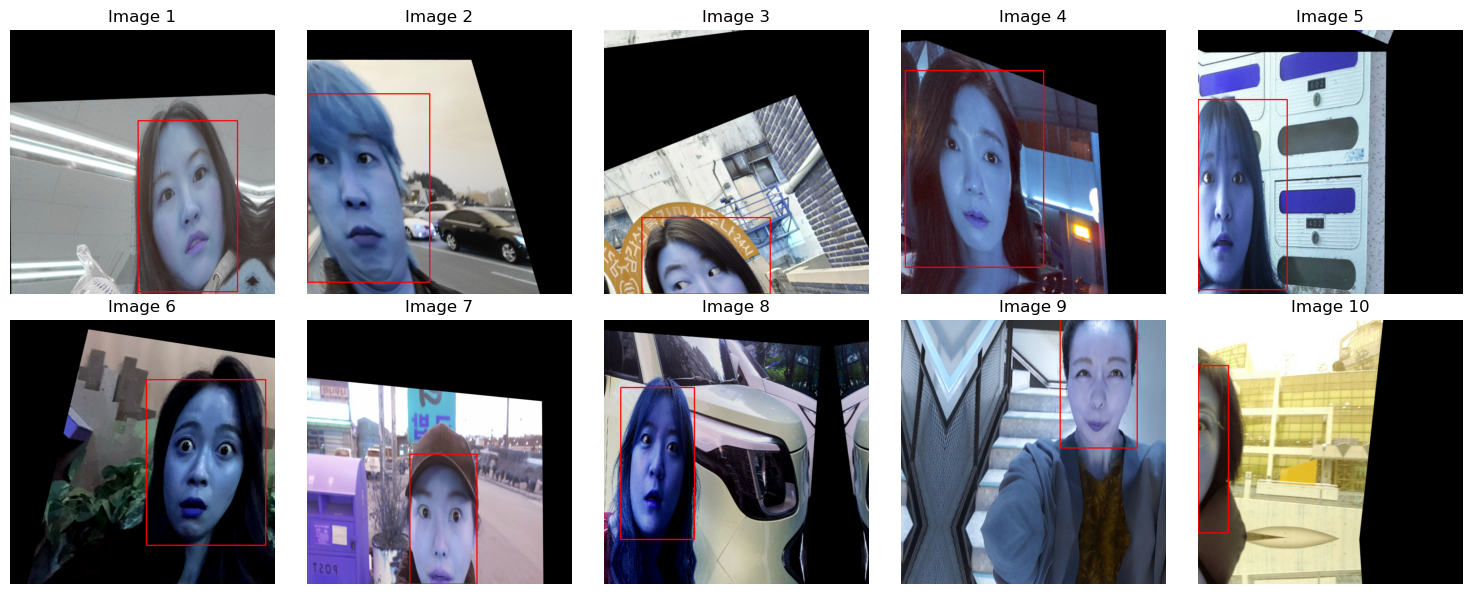

In [15]:
# 이미지와 바운딩 박스 시각화 (증강 데이터)
image_paths = []
boxes = []

for _, row in df_album.head(10).iterrows():
    img_file = row['filename']
    image_path = os.path.join(output_dir, img_file)
    image_paths.append(image_path)

    box_info = {
        'minX': int(row['minX']),
        'minY': int(row['minY']),
        'maxX': int(row['maxX']),
        'maxY': int(row['maxY']),
    }
    boxes.append(box_info)

# 시각화
visualize_images_with_boxes(image_paths, boxes)

Invalid SOS parameters for sequential JPEG


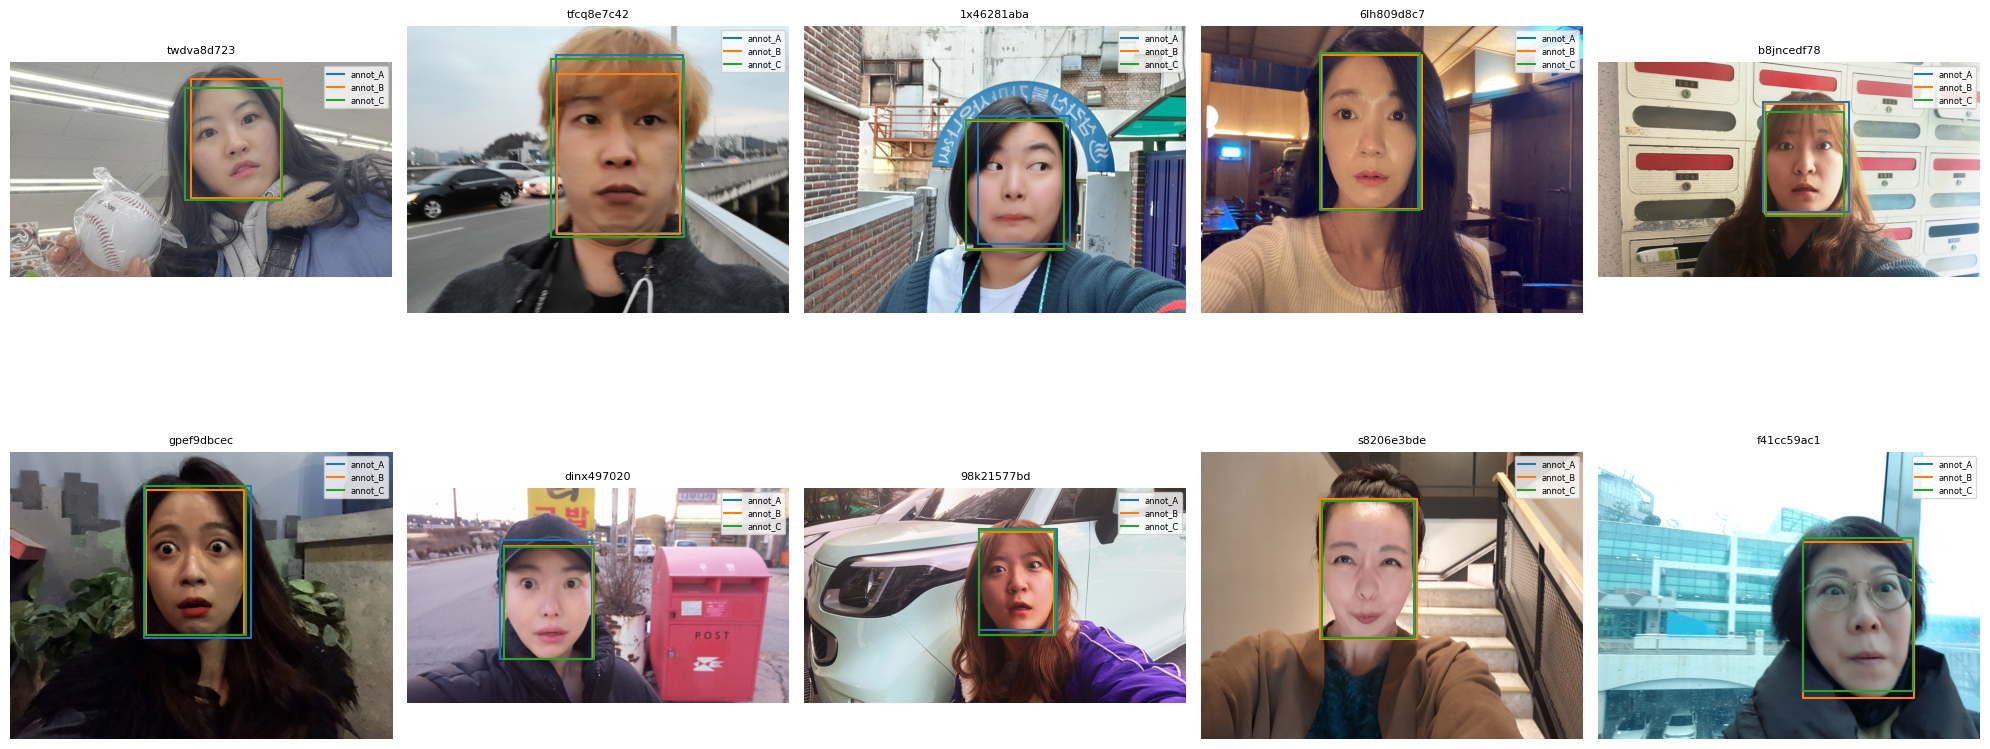

In [16]:
# 이미지와 바운딩 박스 시각화 (원본 데이터)

visualize_boxes(df, img_dir)